# Meta-leraning classification features

**Imports**

In [421]:
# imports

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

**Classification model**

In [459]:
class ClassificationModel():

    def __init__(self, target_label):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]

        self.target_label = target_label
        self.dataset = self.load_dataset()
        self.x_train, self.x_test, self.y_train, self.y_test = self.create_train_test_data()
        self.measures = {}

    def load_dataset(self):

        dataset = pd.read_csv("samples_0_6935_all_defects.csv", sep = ",")
        dataset.drop(columns = ["Unnamed: 0", "image_number", "defect_number"], inplace = True)
        dataset.dropna(inplace = True)

        return dataset
    
    def create_train_test_data(self):

        # Create rust labels:
        target_class_df = self.dataset.copy()
        target_class_df["target_label"] = target_class_df["label"].apply(lambda x: 1 if x == self.target_label else 0)

        # Apply train test split:
        target_class_df = target_class_df.sort_values(by = "target_label", ascending = False)
        number_of_defects = target_class_df["target_label"].sum()
        target_class_df = target_class_df.iloc[:2*number_of_defects, :]
        x = target_class_df.loc[:, self.all_features]
        y = target_class_df.loc[:, "target_label"]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

        return x_train, x_test, y_train, y_test

    def select_features(self, features):

        x_train = self.x_train.loc[:, features]
        x_test = self.x_test.loc[:, features]

        return x_train, x_test
    
    def evaluate(self, y_pred):

        accuracy = accuracy_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred, average=None)[1]

        return accuracy, recall
    
    def run(self, features, number_of_forests=1):

        # Check whether feature combination already exists in measures dictionary:
        feature_combination = ", ".join(sorted(features))
        if feature_combination in self.measures:
            accuracy, recall = self.measures[feature_combination]
        else:

            # Generate train dataset with selected features: 
            x_train, x_test = self.select_features(features)

            # Perform the random forest classifier: 
            for i in range(number_of_forests):
                clf = RandomForestClassifier(n_estimators=50, criterion= "entropy", random_state=i, max_depth=10)
                clf.fit(x_train, self.y_train)
                y_pred = clf.predict(x_test)
                if i == 0:
                    y_pred_final = y_pred
                else:
                    y_pred_final = np.array([1 if y_pred[i] == 1 or y_pred_final[i] == 1 else 0 for i in range(len(y_pred))])

            # Evaluate and store results:
            accuracy, recall = self.evaluate(y_pred_final)
            self.measures[feature_combination] = (accuracy, recall)

        print(f"Feature set: {features}, \nAccuracy: {accuracy}, \nRecall: {recall}\n")
        return recall



In [429]:
rust_classifier = ClassificationModel("Rust")

rust_classifier.run(["gradient", "reddish", "metallic", "dominating_color", "color_bin_2", "color_bin_5", "color_bin_7", 
                     "color_bin_8", "color_bin_9", "rough", "dominating_texture", "texture_2", "texture_3", "texture_6", 
                   "texture_7", "rel_length", "in_shape", "hu_moment_2", "hu_moment_4", "hu_moment_5"])

Feature set: ['gradient', 'reddish', 'metallic', 'dominating_color', 'color_bin_2', 'color_bin_5', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'rough', 'dominating_texture', 'texture_2', 'texture_3', 'texture_6', 'texture_7', 'rel_length', 'in_shape', 'hu_moment_2', 'hu_moment_4', 'hu_moment_5'], 
Accuracy: 0.7592093441150045, 
Recall: 0.8638142447169319



0.8638142447169319

**Environment**

In [460]:
class State():

    def __init__(self, action):

        self.binary = action.float()


class Dacl10kEnvironment():

    def __init__(self, target_label):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]
        
        self.classifier = ClassificationModel(target_label)
        self.features_dict = {i: feature for i, feature in enumerate(self.all_features)}
        self.statesize = len(self.all_features)

        self.initial_state = State(torch.FloatTensor([i % 2 for i in range(len(self.all_features))]))

        self.table = {}

    def step(self, action):

        next_state = State(action)
        features_indices = [i for i, value in enumerate(action) if value == 1]
        features = [self.features_dict[i] for i in features_indices]
        reward = self.classifier.run(features)
        self.table[tuple([self.features_dict[i] for i, binary in enumerate(tuple(action.detach().numpy())) if binary == 1])] = reward

        return next_state, reward


**Reinforcement Agent**

In [461]:
class FeedforwardNet(nn.Module):

    def __init__(self, env, device, hidden_size):

        super(FeedforwardNet, self).__init__()
        
        self.device = device
        self.statesize = env.statesize
        self.hidden_size = hidden_size
        
        self.hidden_layer = nn.Linear(self.statesize, self.hidden_size).to(self.device)
        self.output_layer = nn.Linear(self.hidden_size, self.statesize).to(self.device)
        self.sigmoid = nn.Sigmoid().to(self.device)

    def forward(self, input):

        x = self.hidden_layer(input)
        x = torch.relu(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)

        return x


class ReinforcementAgent():

    def __init__(self, env):

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = FeedforwardNet(env, self.device, 50)

        self.optimizer = torch.optim.Adam(self.net.parameters(),lr=0.01)

    def step(self, state):

        probabilities = self.net.forward(state.binary)
        #print(probabilities)
        action = torch.bernoulli(probabilities)

        # If no feature remaining in action, include highest likelihood features
        if torch.sum(action == 1).item() < 1:
            _, max_likelihood_features = torch.topk(probabilities, 5)
            action[max_likelihood_features] = 1

        return action

    def update(self, reward):

        reward = torch.tensor(reward, dtype=torch.float32, requires_grad=True)
        loss = -torch.log(reward)
        #print(f"Loss: {loss}")

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



**Train the reinforcement agent**

In [462]:
def plot_rewards(rewards):

    x = list(range(len(rewards)))
    plt.figure(figsize=(10, 5))
    plt.plot(x, rewards, marker="o", linestyle="-", color="b")

    plt.title("Rewards")
    plt.xlabel("Epoch")
    plt.ylabel("Reward")
    plt.grid(True)

    plt.show()

def train_agent(defect, epochs=500):

    env = Dacl10kEnvironment(defect)
    agent = ReinforcementAgent(env)

    state = env.initial_state
    rewards = []

    for i in range(epochs): 

        print(f"Epoch {i}")
        
        action = agent.step(state)
        #print(action)
        next_state, reward = env.step(action)
        agent.update(reward)
        state = next_state

        print(f"Reward: {reward}\n")
        rewards.append(reward)

    plot_rewards(rewards)

    best_feature_set = max(env.table, key=lambda k: env.table[k])
    print(f"Best Feature set: {best_feature_set}\nReward: {env.table[best_feature_set]}")

Epoch 0
Feature set: ['gradient', 'reddish', 'metallic', 'black_thin', 'color_bin_1', 'color_bin_3', 'color_bin_4', 'color_bin_7', 'color_bin_9', 'dominating_texture', 'texture_0', 'texture_4', 'texture_5', 'texture_7', 'texture_8', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7526205450733753, 
Recall: 0.8512914166449257

Reward: 0.8512914166449257

Epoch 1
Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'color_bin_1', 'color_bin_2', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_9', 'texture_5', 'number_lengthy_objects', 'roundness', 'hu_moment_1', 'hu_moment_5', 'hu_moment_7'], 
Accuracy: 0.7566636717580114, 
Recall: 0.8593790764414296

Reward: 0.8593790764414296

Epoch 2
Feature set: ['gradient', 'reddish', 'metallic', 'black_thin', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_entropy', 'rough', 'texture_5', 'texture_6', 'texture_7', 'tex

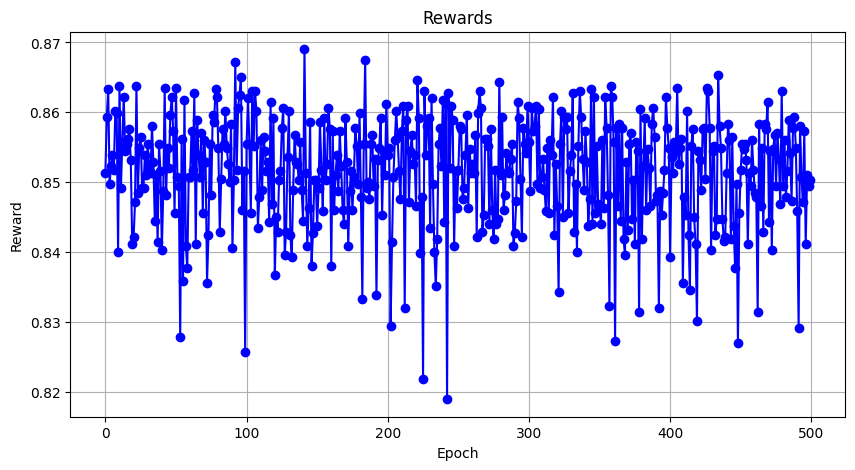

Best Feature set: ('darker', 'reddish', 'metallic', 'black', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'rough', 'texture_2', 'texture_4', 'texture_5', 'texture_7', 'rough_entropy', 'in_shape', 'roundness', 'hu_moment_4', 'hu_moment_5', 'hu_moment_7')
Reward: 0.8690320897469345


In [463]:
train_agent("Rust")

Epoch 0
tensor([0.4292, 0.5746, 0.4955, 0.4320, 0.4592, 0.4744, 0.4999, 0.4486, 0.5324,
        0.5294, 0.4856, 0.4995, 0.5014, 0.4028, 0.4710, 0.4503, 0.5212, 0.5073,
        0.4919, 0.4750, 0.6096, 0.4795, 0.4559, 0.4360, 0.4331, 0.5090, 0.5038,
        0.6020, 0.4187, 0.5155, 0.4323, 0.5470, 0.4672, 0.5041, 0.4620, 0.5043,
        0.5042, 0.6159, 0.4934, 0.5174, 0.5001, 0.5152, 0.5561, 0.4949],
       grad_fn=<SigmoidBackward0>)
tensor([1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0.], grad_fn=<BernoulliBackward0>)
Feature set: ['darker', 'gradient', 'metallic', 'black', 'dominating_color', 'color_bin_1', 'color_bin_8', 'color_bin_9', 'dominating_texture', 'texture_0', 'texture_1', 'texture_4', 'texture_7', 'texture_9', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'hu_moment_1', 'hu_moment_3', 'hu_moment_5'], 
Accuracy: 0.784363177805800

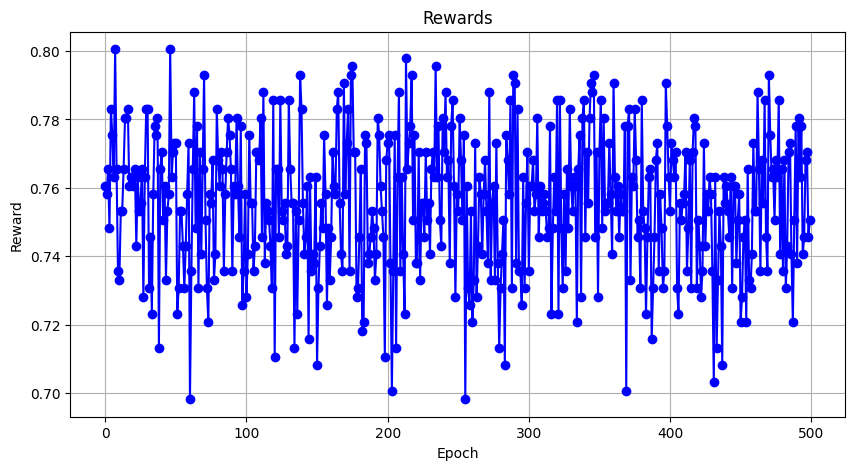

Best Feature set: ('darker', 'gradient', 'metallic', 'black', 'black_thin', 'dominating_color', 'color_bin_3', 'color_bin_8', 'texture_1', 'texture_3', 'texture_4', 'texture_6', 'texture_8', 'texture_9', 'rough_entropy', 'rel_length', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_5', 'hu_moment_6')
Reward: 0.800498753117207


In [ ]:
train_agent("Drainage")


Epoch 0
Feature set: ['darker', 'reddish', 'metallic', 'colorful', 'black', 'color_bin_1', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_entropy', 'dominating_texture', 'texture_2', 'texture_3', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7997685185185185, 
Recall: 0.7892376681614349

Reward: 0.7892376681614349

Epoch 1
Feature set: ['metallic', 'colorful', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_7', 'color_bin_9', 'rough', 'texture_3', 'texture_5', 'texture_7', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'rel_length', 'hu_moment_4', 'hu_moment_7'], 
Accuracy: 0.8148148148148148, 
Recall: 0.8430493273542601

Reward: 0.8430493273542601

Epoch 2
Feature set: ['darker', 'colorful', 'dominating_color', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_9', 'rough', 'dominating_texture', 'texture_0', 'texture_3', 'texture_4', 'texture_7', 'te

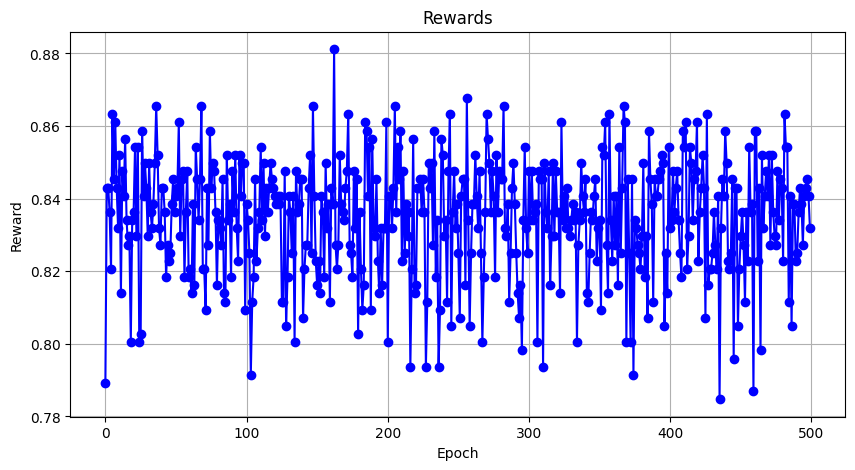

Best Feature set: ('gradient', 'colorful', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_4', 'color_bin_8', 'color_bin_9', 'rough', 'dominating_texture', 'texture_5', 'texture_6', 'texture_8', 'texture_9', 'rough_entropy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'roundness', 'hu_moment_1', 'hu_moment_4')
Reward: 0.8811659192825112


In [464]:
train_agent("Wetspot")

In [465]:
train_agent("Graffiti")

Epoch 0
Feature set: ['gradient', 'metallic', 'colorful', 'black', 'dominating_color', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_7', 'color_bin_9', 'color_entropy', 'rough', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_7', 'texture_9', 'rough_entropy', 'number_lengthy_objects', 'roundness', 'hu_moment_1', 'hu_moment_4', 'hu_moment_5', 'hu_moment_7'], 
Accuracy: 0.8368794326241135, 
Recall: 0.8433734939759037

Reward: 0.8433734939759037

Epoch 1
Feature set: ['gradient', 'black', 'black_thin', 'color_bin_2', 'color_bin_3', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_6', 'texture_7', 'texture_9', 'rough_entropy', 'lengthy', 'in_shape', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6'], 
Accuracy: 0.8315602836879432, 
Recall: 0.8278829604130808

Reward: 0.8278829604130808

Epoch 2
Feature set: ['darker', 'gradient', 'colorful', 'black', 'd

KeyboardInterrupt: 

In [ ]:
train_agent("ExposedRebars")

In [ ]:
train_agent("Crack")